#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.


Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTree" data-toc-modified-id="DecisionTree-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTree</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Построение-графика" data-toc-modified-id="Построение-графика-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Построение графика</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
import  scipy.signal.signaltools
 
def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]
 
scipy.signal.signaltools._centered = _centered
 
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, cv, Pool
RS=1234

warnings.filterwarnings('ignore')
sns.set()
plt.rcParams['figure.figsize'] = 15, 8

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col='datetime', parse_dates=True)

Рассмотрим первые 5 строк таблицы:

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Рассмотрим основную информацию о таблице:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Рассмотрим описательные статистики:

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


Проверим метки данных на монотонность:

In [7]:
df.index.is_monotonic

True

Проверим данные на пропуски:

In [8]:
df.isna().sum()

num_orders    0
dtype: int64

Ресэмплируем данные по одному часу:

In [9]:
df = df.resample('1H').sum()

Рассчитаем скользящее среднее, а также среднее и стандартное отклонение:

In [10]:
df['rolling_mean'] = df.rolling(50).mean()
df['mean'] = df['rolling_mean'].mean()
df['std'] = df['rolling_mean'].std()

### Вывод

Данные загружены и подготовлены для дальнейшего анализа.

## Анализ

Построим временной ряд, а также аппроксимируем его кривой скользящего среднего:

<AxesSubplot:xlabel='datetime'>

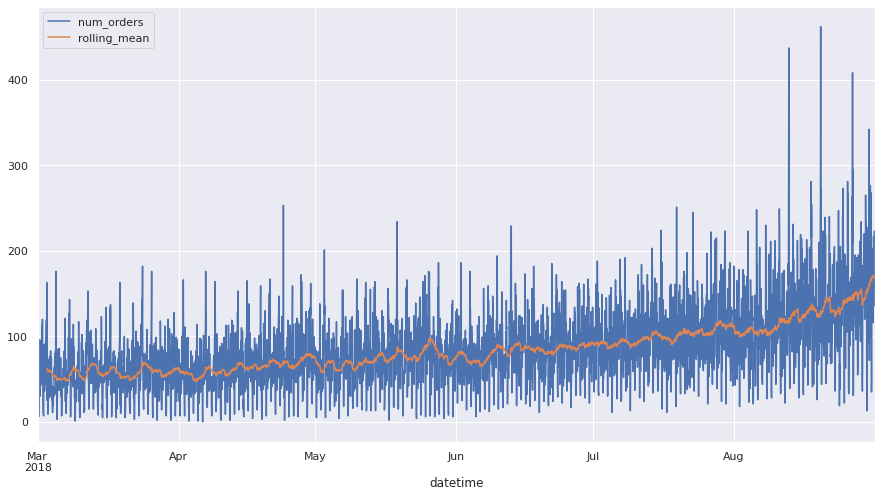

In [11]:
df[['num_orders', 'rolling_mean']].plot(ax=plt.gca())

Проверим процесс на стационарность. Для этого построим графики среднего и стандартного отклонения:

<AxesSubplot:xlabel='datetime'>

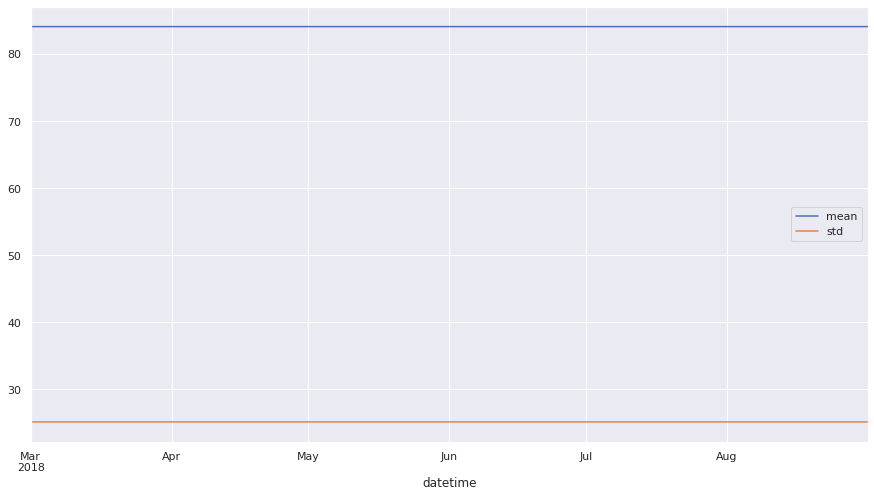

In [12]:
df[['mean', 'std']].plot(ax=plt.gca())

Таким образом, среднее и стандартное отклонение на всю промежутке константны - следовательно, процесс стационарный.

Разобьем ряд на тренд и сезонность:

In [13]:
decomposed = seasonal_decompose(df['num_orders'])

Построим графики тренда, сезонности и шумов:

<AxesSubplot:xlabel='datetime'>

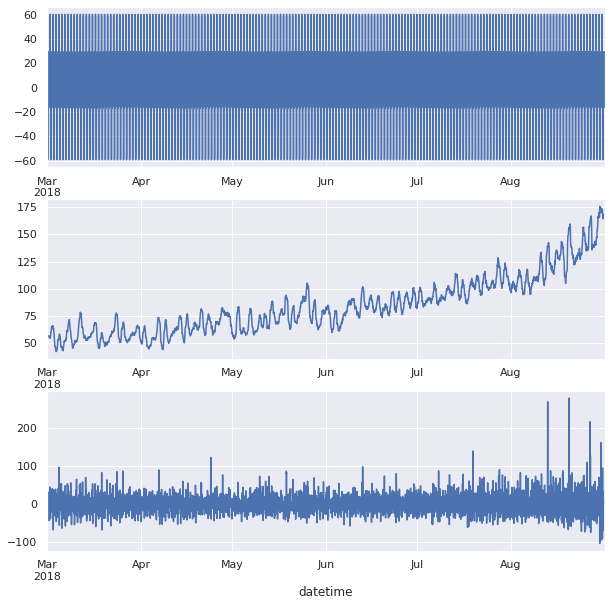

In [14]:
plt.figure(figsize=(10,10))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

Исследуем подробнее сезонность на конкретных интервалах:

<AxesSubplot:xlabel='datetime'>

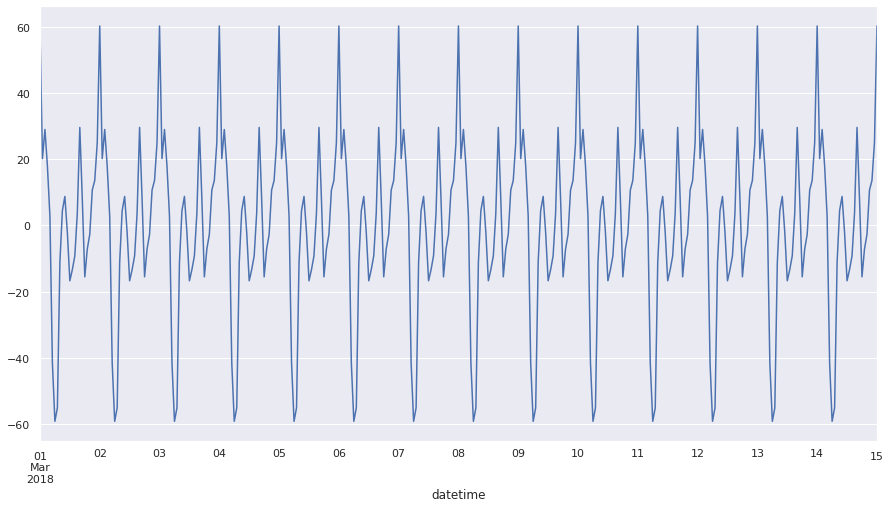

In [15]:
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-15 00:00:00'].plot(ax=plt.gca())

Данных график показывает сезонность в течение 15 дней марта. Сезонность проявляется на суточном интервале:

<AxesSubplot:xlabel='datetime'>

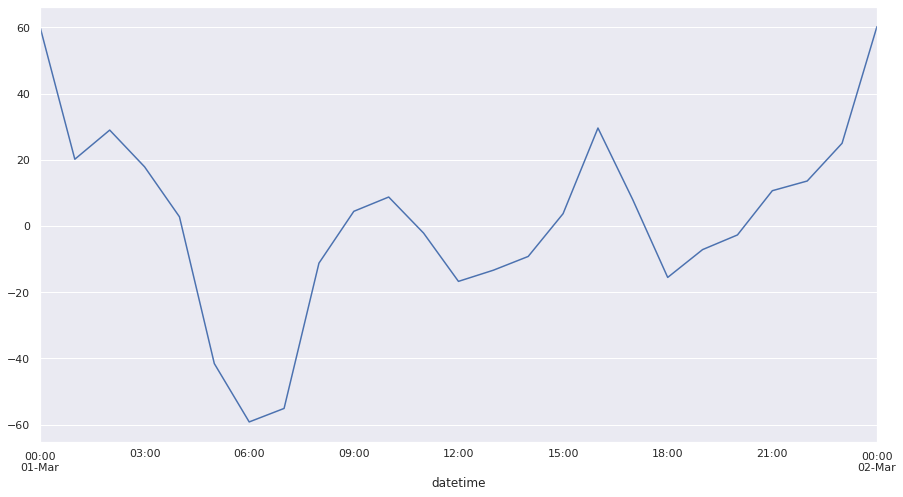

In [16]:
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-02 00:00:00'].plot(ax=plt.gca())

Построим график тренда с его аппроксимацией скользящим среднем:

<AxesSubplot:xlabel='datetime'>

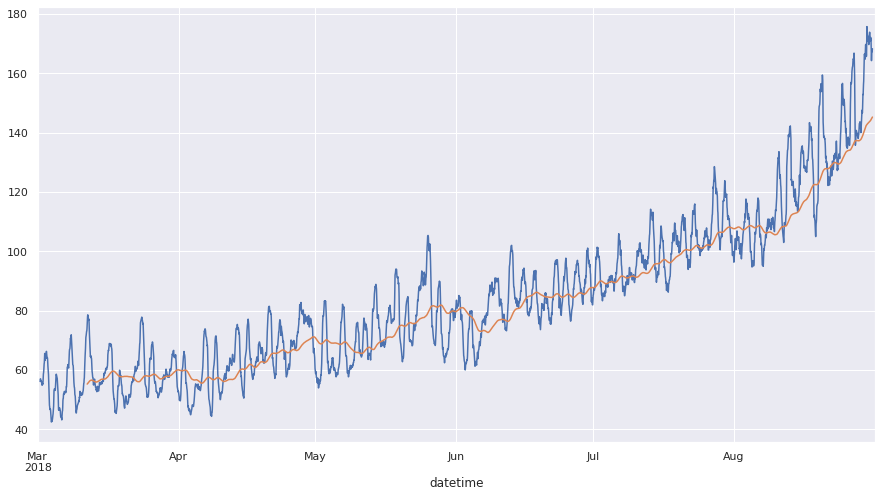

In [17]:
decomposed.trend.plot()
decomposed.trend.rolling(250).mean().plot()

Добавим новый набор признаков в данные:

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1, max_lag + 1):
        data[f'lag_{i}'] = data['num_orders'].shift(i)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [21]:
make_features(df, 5, 250)

In [22]:
df.head()

,num_orders,rolling_mean,mean,std,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,,,
2018-03-03 01:00:00,108,NaN,84.099418,25.148001,5,1,NaN,NaN,NaN,NaN,NaN
2018-03-03 02:00:00,25,NaN,84.099418,25.148001,5,2,108.0,NaN,NaN,NaN,NaN
2018-03-03 03:00:00,64,NaN,84.099418,25.148001,5,3,25.0,108.0,NaN,NaN,NaN
2018-03-03 04:00:00,44,NaN,84.099418,25.148001,5,4,64.0,25.0,108.0,NaN,NaN
2018-03-03 05:00:00,15,NaN,84.099418,25.148001,5,5,44.0,64.0,25.0,108.0,NaN


Избавимся от пропусков:

In [23]:
df.dropna(inplace=True)

### Вывод

Таким образом, исследуется стационарный процесс.

Тренд показывает планомерное увеличение числа заказов с Марта по Август.

Сезонность наблюдается в течение суток: наибольшее количество заказов приходится на утренний и вечерний интервал - так называемые часы пик. Однако, максимум заказов наблюдается в период с 00:00 до 03:00. Минимум заказов приходится на раннее утро.

## Обучение

Подготовим данные:

In [24]:
data = df.drop(['mean', 'std'], axis=1).copy()

In [25]:
data.head()

,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,
2018-03-13 11:00:00,75,55.396,1,11,53.0,44.0,57.0,20.0,15.0
2018-03-13 12:00:00,34,55.264,1,12,75.0,53.0,44.0,57.0,20.0
2018-03-13 13:00:00,40,55.300,1,13,34.0,75.0,53.0,44.0,57.0
2018-03-13 14:00:00,50,55.204,1,14,40.0,34.0,75.0,53.0,44.0
2018-03-13 15:00:00,69,55.228,1,15,50.0,40.0,34.0,75.0,53.0


In [26]:
X = data.drop('num_orders', axis=1)
y = data['num_orders']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=RS)

Для начала рассмотрим то значение исследуемой метрики, которое покажет случайная модель. Основываясь на полученном результате будем проверять на "глупость" исследуемые модели.

In [28]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
predictions = dummy.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, predictions)))

84.78447247512008


### CatBoost

In [29]:
catboost = CatBoostRegressor()

In [30]:
params = {'iterations': range(1000, 5001, 1000),
          'depth': range(5, 12, 2),
          'learning_rate': np.arange(0.1, 0.51, 0.1),
          'l2_leaf_reg': np.arange(3, 10, 1),
          'verbose': [1000],
         }

In [31]:
test_size = 0.1
n_splits = int((1 // test_size) - 1)
print(n_splits)

8


In [56]:
tsvc = TimeSeriesSplit(n_splits=8)

In [57]:
grid = catboost.grid_search(params, X_train, y_train, cv=tsvc)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 74.2657379	test: 108.4065141	best: 108.4065141 (0)	total: 1.59ms	remaining: 1.59s
999:	learn: 10.4820032	test: 31.2928570	best: 30.9523599 (461)	total: 1.16s	remaining: 0us

bestTest = 30.95235991
bestIteration = 461

0:	loss: 30.9523599	best: 30.9523599 (0)	total: 1.74s	remaining: 20m 19s
0:	learn: 67.5271757	test: 101.2157576	best: 101.2157576 (0)	total: 1.58ms	remaining: 1.58s
999:	learn: 6.8046009	test: 30.8570721	best: 30.1232560 (276)	total: 1.24s	remaining: 0us

bestTest = 30.12325598
bestIteration = 276

1:	loss: 30.1232560	best: 30.1232560 (1)	total: 3s	remaining: 17m 26s
0:	learn: 60.9539236	test: 94.1092899	best: 94.1092899 (0)	total: 1.35ms	remaining: 1.35s
999:	learn: 4.7302363	test: 32.6892367	best: 30.6528873 (198)	total: 1.19s	remaining: 0us

bestTest = 30.65288727
bestIteration = 198

2:	loss: 30.6528873	best: 30.1232560 (1)	total: 4.21s	remaining: 16m 17s
0:	learn: 54.6057142	test: 87.1077446	best: 87.1077446 (0)	total: 1.78ms	remaining: 1.78s
999:	learn: 3.

In [58]:
best_params = grid['params']

In [59]:
best_params

{'depth': 5,
 'verbose': 1000,
 'l2_leaf_reg': 7,
 'iterations': 1000,
 'learning_rate': 0.2}

In [60]:
catboost = CatBoostRegressor(**best_params)

In [61]:
catboost.fit(X_train, y_train)

0:	learn: 35.5164846	total: 1.49ms	remaining: 1.49s
999:	learn: 10.0928769	total: 1.27s	remaining: 0us


### LinearRegression

In [63]:
lr = LinearRegression()

In [64]:
cross_val_score(lr, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3).mean()

-31.08497674011157

In [65]:
lr.fit(X_train, y_train)

LinearRegression()

### DecisionTree

In [66]:
tree = DecisionTreeRegressor()

In [67]:
cross_val_score(tree, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3).mean()

-38.75970416768353

In [68]:
tree.fit(X_train, y_train)

DecisionTreeRegressor()

### Вывод

Было построены три модели:
* CatBoost
* Линейная регрессия
* Решающее дерево

Для модели градиентного бустинга был реализован подбор гиперпараметров методом `GridSearchCV`

## Тестирование

Протестируем модели на реальных данных:

In [69]:
for model in [catboost, lr, tree]:
    predictions = model.predict(X_test)
    print(f'RMSE для модели {model} = {((np.sqrt(mean_squared_error(y_test, predictions)))):.2f}')

RMSE для модели <catboost.core.CatBoostRegressor object at 0x7ff55d3bb640> = 46.69
RMSE для модели LinearRegression() = 50.38
RMSE для модели DecisionTreeRegressor() = 66.51


### Построение графика 

In [32]:
params = {'depth': 5,
 'verbose': 1000,
 'l2_leaf_reg': 7,
 'iterations': 1000,
 'learning_rate': 0.2}

In [33]:
catboost = CatBoostRegressor(**params)

In [35]:
catboost.fit(X_train, y_train)
predictions = catboost.predict(X_test)

0:	learn: 35.5469120	total: 2.1ms	remaining: 2.09s
999:	learn: 9.8396957	total: 1.78s	remaining: 0us


In [58]:
pred = pd.Series(predictions)
pred.index = y_test.index

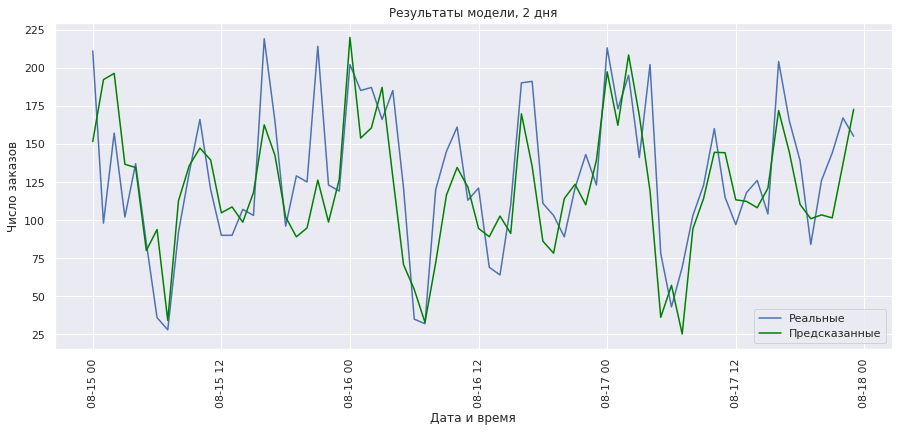

In [82]:
fig2, ax = plt.subplots(figsize=(15, 6))
ax = sns.lineplot(data=y_test['2018-08-15':'2018-08-17'], label='Реальные')
sns.lineplot(data=pred['2018-08-15':'2018-08-17'], color='green', label='Предсказанные')
plt.xticks(rotation=90)
#plt.xlim('2018-08-15', '2018-08-17')
plt.title('Результаты модели, 2 дня')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов');

### Вывод

Таким образом, наилучшим образом показала себя модель **CatBoostRegressor**: ее показатель `RMSE` составил **42.95**

## Общий вывод

В данном исследование были изучены данные о заказах такси в аэропортах, представленные в форме временного ряда. Данный процесс считается стационарным.

Анализ тренда и сезонности данного процесса показал, что количество заказов значительно выросло в периоде с Марта по Август. Также наблюдается определенный формат сезонности в течении суток - пики утром и вечером, максимум в период поздней ночи, минимум в период раннего утра.

Для прогнозирования заказов изучены несколько моделей машинного обучения. Наилучшей моделью стала модель, основнная на методе градиентного бустинга - **CatBoost**, `RMSE`, которой составил **42.95**.